In [69]:
%pylab inline
import uproot

Populating the interactive namespace from numpy and matplotlib


In [461]:
import random
import awkward0 as ak

## Load data files

In [2]:
s500_dm1_file =  uproot.open("mc_392924.SlepSlep_direct_500p5_1p0_2L8.exactly2lep.root")

In [3]:
s100_dm50_file =  uproot.open("mc_392925.SlepSlep_direct_100p0_50p0_2L8.exactly2lep.root")

In [4]:
s200_dm100_file = uproot.open("mc_392936.SlepSlep_direct_200p0_100p0_2L8.exactly2lep.root")

In [16]:
data_file = uproot.open("data_A.exactly2lep.root")

In [22]:
b_ZZ_qqll = uproot.open("mc_363356.ZqqZll.exactly2lep.root")

In [23]:
b_WZ_qqll = uproot.open("mc_363358.WqqZll.exactly2lep.root")

In [24]:
b_dib_llvv = uproot.open("mc_363492.llvv.exactly2lep.root")

In [46]:
bg = [b_ZZ_qqll, b_WZ_qqll, b_dib_llvv]

In [86]:
sets = [s500_dm1_file, s100_dm50_file, s200_dm100_file]

In [96]:
#files_1 = [data_file, s500_dm1_file]
#files_2 = [data_file, s100_dm50_file]
#files_3 = [data_file, s200_dm100_file]

In [97]:
#files_1.extend(bg)
#files_2.extend(bg)
#files_3.extend(bg)
allfiles = [data_file]
allfiles.extend(sets)
allfiles.extend(bg)

## Functions

In [90]:
SMALL_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize= (7, 5))

In [91]:
def make_fig(xTitle="xTitle",yTitle="yTitle"):
    fig = plt.figure()

    ax = plt.gca()
    ax.set_prop_cycle(color=['#002BFF','#A15FFF','#FF0061','#FF8913'])
    ax.set_xlabel(xTitle,labelpad=6)
    ax.set_ylabel(yTitle)
    ax.tick_params(direction='out', length=8, width=2)
    ax.yaxis.offsetText.set_fontsize(10)
    #ax.xaxis.labelpad = 15
    #ax.yaxis.labelpad = 15
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    return fig, ax

In [465]:
def mt2(file, mdm, indices = None):
    mets = file[b'mini;1'].array(b'met_et')
    mets_phi = file[b'mini;1'].array(b'met_phi')
    lep_pt = file[b'mini;1'].array(b'lep_pt')
    lep_eta = file[b'mini;1'].array(b'lep_eta')
    lep_e = file[b'mini;1'].array(b'lep_E')
    lep_phi = file[b'mini;1'].array(b'lep_phi')
    if indices is not None:
        mets = np.take(mets, indices)
        mets = ak.fromiter(mets)
        mets_phi = np.take(mets_phi, indices)
        mets_phi = ak.fromiter(mets_phi)
        lep_pt = np.take(lep_pt, indices)
        lep_pt = ak.fromiter(lep_pt)
        lep_eta = np.take(lep_eta, indices)
        lep_eta = ak.fromiter(lep_eta)
        lep_phi = np.take(lep_phi, indices)
        lep_phi = ak.fromiter(lep_phi)
        lep_e = np.take(lep_e, indices)
        lep_e = ak.fromiter(lep_e)

    lep_p = np.multiply(lep_pt, np.cosh(lep_eta))
    mpts = np.sqrt(mets**2 - mdm**2)
    lep_et = lep_e*(lep_pt/lep_p)
    
    splittings_mag = []
    for mpt in mpts:
        splittings_mag.append(np.linspace(0, mpt, 10))
    s_phi = np.linspace(0, 2*pi, 10)
    
    mt2 = []
    for i, qs in enumerate(splittings_mag):
        #print(i)
        max_mtq = []
        for q in qs:
            eq = np.sqrt(q**2 + mdm**2)
            vec_mpt = np.array([[mpts[i]*np.cos(mets_phi[i]), mpts[i]*np.sin(mets_phi[i])]]*len(s_phi))
            vec_q = np.column_stack([q*np.cos(s_phi), q*np.sin(s_phi)])
            vec_minq = np.array(vec_mpt - vec_q)
            vec_lep1 = np.array([[lep_pt[i][0]*np.cos(lep_phi[i][0]), lep_pt[i][0]*np.sin(lep_phi[i][0])]]*len(s_phi))
            vec_lep2 = np.array([[lep_pt[i][1]*np.cos(lep_phi[i][1]), lep_pt[i][1]*np.sin(lep_phi[i][1])]]*len(s_phi))
            eqmin = np.sqrt(np.array([sum(x) for x in np.multiply(vec_minq, vec_minq)]) + mdm**2)
            
            p1qt = np.array([sum(x) for x in np.multiply(vec_q, vec_lep1)])
            p2mqt = np.array([sum(x) for x in np.multiply(vec_minq, vec_lep2)])
            
            mtalpha = np.sqrt(2*(lep_et[i][0]*eq - p1qt))
            mtbeta =  np.sqrt(2*(lep_et[i][1]*eqmin - p2mqt))
            #mtalpha = np.where(np.isnan(mtalpha), -1, mtalpha)
            #mtbeta = np.where(np.isnan(mtbeta), -1, mtbeta)
            
            max_mtq.append(np.where(mtalpha >= mtbeta, mtalpha, mtbeta))
        max_mtq = np.array(max_mtq)
        mask = (np.isnan(max_mtq))
        max_mtq[mask] = -1
        max_mtq[mask] = np.max(max_mtq)+1
        mt2.append(np.min(max_mtq))
    return np.array(mt2)

In [329]:
def filter_slep(file, mdm):
    lep_type = file[b'mini;1'].array(b'lep_type')
    lep_char = file[b'mini;1'].array(b'lep_charge')
    mets = file[b'mini;1'].array(b'met_et')
    jets = file[b'mini;1'].array(b'jet_n')
    lep_ts = np.array([np.sum(lt) for lt in lep_type])
    lep_cs = np.array([np.sum(ls) for ls in lep_char])
    njets = np.array([np.sum(j) for j in jets])
    
    ind1 = np.where(mets >= mdm)[0]
    ind2 = np.where(lep_ts != 24)[0]
    ind3 = np.where(lep_cs == 0)[0]
    ind4 = np.where(njets == 0)[0]
    indices = np.intersect1d(np.intersect1d(ind3, ind2), ind1)
    indices = np.intersect1d(ind4, indices)
    return indices

In [281]:
def get_N(file):
    return 1000*file[b'mini;1'].array(b'XSection')/file[b'mini;1'].array(b'SumWeights')

## Analysis of MC datasets

Look at MET distribution of MC datasets.

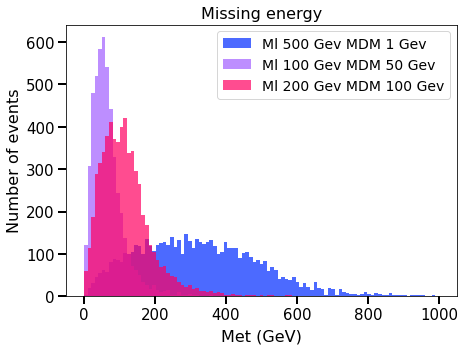

In [94]:
make_fig("Met (GeV)", "Number of events")
title("Missing energy")
nbins   = 100 # number of bins in histogram
xlow    = 0
xhigh   = 1000
bins    = np.linspace(xlow, xhigh, nbins)
for i in range(len(sets)):
    n, bins, patches = plt.hist(sets[i][b'mini;1'].array('met_et')/1e3, bins, alpha = 0.7)
legend(["Ml 500 Gev MDM 1 Gev", "Ml 100 Gev MDM 50 Gev", "Ml 200 Gev MDM 100 Gev"])

We build something called "stransverse mass". Recall regular transverse mass for a 1-> 2 decay:
\begin{align}
m_T = \sqrt{2 (E_{T1}E_{T2} - \mathbf{p_{T1}\cdot p_{T2}})}
\end{align}
or 
\begin{align}
m_T = \sqrt{2 (E_{T1}E_{T2} - |p_{T1}||p_{T2}|\cos(\Delta \phi)}
\end{align}
Where 
\begin{align}
E_T = E\frac{|p_T|}{|p|}
\end{align}
and
\begin{align}
m_T \leq m
\end{align}

Here, we have two $\tilde l-> l + DM$, where the $DM$ goes into $MET$. However, we don't know how the $MET$ is split up between the two unknown $DM$ particles, which means we have to split $\mathbf{p_{T}}^{miss}$ into all possible combinations $\mathbf{q_T}$ and $\mathbf{p_{T}}^{miss} - \mathbf{q_T}$. Then, we define the the $m_{T2}$ variable ("stransverse mass") as:
\begin{align}
m_{T2} = \text{min}_{\mathbf{q_T}}\bigg \{\text{max} \big[m_T(\mathbf{p_T^{\alpha}}, \mathbf{q_T}, MDM), m_T(\mathbf{p_T^{\beta}}, \mathbf{p_{T}}^{miss} - \mathbf{q_T}, MDM)]\big]\bigg\}
\end{align}

Where $\alpha$ and $\beta$ indicate the two respective $\tilde{l} -> l + DM$ decays we are looking at.

Note that we assume $|p_T| \approx |p|$.

$m_{T2}$ satisfies the inequality:
\begin{align}
m_{T2}^2 \leq m_{\tilde l}^2 - MDM^2
\end{align}

In [322]:
mt2_sets = []
mdms = [1e3, 50e3, 100e3]
for i, s in enumerate(sets):
    mt2_sets.append(mt2(s, mdms[i]))

C:\Users\Wenjie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


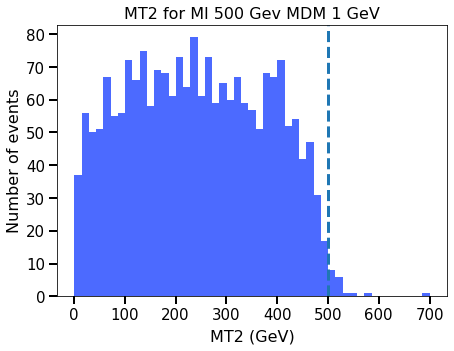

In [429]:
make_fig("MT2 (GeV)", "Number of events")
title("MT2 for Ml 500 Gev MDM 1 GeV")
nbins   = 50 # number of bins in histogram
xlow    = 1
xhigh   = 700
bins    = np.linspace(xlow, xhigh, nbins)
n, bins, patches = plt.hist(np.take(np.array(mt2_sets[0])/1e3, cut_ind_sets[0]), bins, alpha = 0.7)
axvline(np.sqrt(500**2-(mdms[0]/1e3)**2), linestyle = "--")

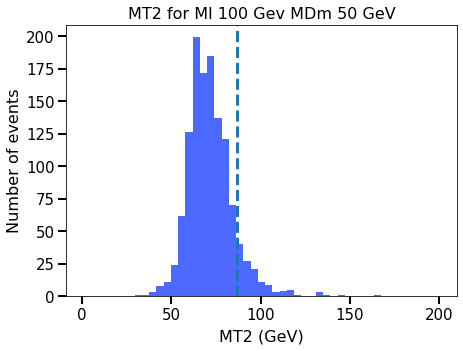

In [430]:
make_fig("MT2 (GeV)", "Number of events")
title("MT2 for Ml 100 Gev MDm 50 GeV")
nbins   = 50 # number of bins in histogram
xlow    = 1
xhigh   = 200
bins    = np.linspace(xlow, xhigh, nbins)
n, bins, patches = plt.hist(np.take(np.array(mt2_sets[1])/1e3, cut_ind_sets[1]), bins, alpha = 0.7)
axvline(np.sqrt(100**2-(mdms[1]/1e3)**2), linestyle = "--")

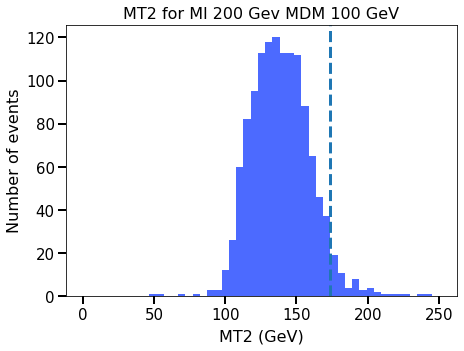

In [432]:
make_fig("MT2 (GeV)", "Number of events")
title("MT2 for Ml 200 Gev MDM 100 GeV")
nbins   = 50 # number of bins in histogram
xlow    = 1
xhigh   = 250
bins    = np.linspace(xlow, xhigh, nbins)
n, bins, patches = plt.hist(np.take(np.array(mt2_sets[2])/1e3, cut_ind_sets[2]), bins, alpha = 0.7)
axvline(np.sqrt(200**2-(mdms[2]/1e3)**2), linestyle = "--")

For all data sets, I will make the cuts that the lepton type should be either two muons or two electrons and the sum of the lepton charge should be -1.

In [286]:
weights = ["scaleFactor_MUON", "scaleFactor_ELE", "scaleFactor_PILEUP", "scaleFactor_LepTRIGGER", "mcWeight"]

## Random sampling of data

In [352]:
cut_ind_databg = []
for mdm in mdms:
    for file in [data_file] + bg:
        cut_ind_databg.append(filter_slep(file, mdm))

In [351]:
cut_ind_sets = []
for i, file in enumerate(sets):
    cut_ind_sets.append(filter_slep(file, mdms[i]))

In [356]:
sizes_databg = []
for file in [data_file] + bg:
    met = file[b'mini;1'].array(b'met_et')
    sizes_databg.append(len(met))

In [397]:
rand_samp_databg = []
for j, mdm in enumerate(mdms):
    mdm_samp = []
    for i, file in enumerate([data_file] + bg):
        if j <=1:
            mdm_samp.append(random.sample(range(0, sizes_databg[i]), 10000*(j+1)))
        else:
            mdm_samp.append(random.sample(range(0, sizes_databg[i]), 100000))
    rand_samp_databg.append(mdm_samp)

In [361]:
cut_ind_dbg = []
cut_ind_dbg.append(cut_ind_databg[0:4])
cut_ind_dbg.append(cut_ind_databg[4:8])
cut_ind_dbg.append(cut_ind_databg[8:12])

In [398]:
cut_ind_dbg = np.array(cut_ind_dbg)
cut_ind_sets = np.array(cut_ind_sets)
rand_samp_databg = np.array(rand_samp_databg)

C:\Users\Wenjie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [399]:
fin_ind_dbg = []
for i in range(len(cut_ind_dbg)):
    mdm_ind = []
    for j in range(len(cut_ind_dbg[0])):
        mdm_ind.append(np.intersect1d(cut_ind_dbg[i][j], rand_samp_databg[i][j]))
    fin_ind_dbg.append(mdm_ind)

In [408]:
fin_ind_dbg = np.array(fin_ind_dbg)

C:\Users\Wenjie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [412]:
for i, fin_ind in enumerate(fin_ind_dbg):
    np.save(f"mdm{i}fin_ind_dbg.txt", fin_ind)

In [413]:
np.save("fin_ind_dbg_whole", fin_ind_dbg)

In [466]:
mt2_dbg = []
for i in range(len(fin_ind_dbg)):
    mt2_mdm = []
    for j, file in enumerate([data_file] + bg):
        print(f'{i}{j}')
        mt2_mdm.append(mt2(file, mdms[i], fin_ind_dbg[i][j]))
    mt2_dbg.append(mt2_mdm)

00
01
02
03
10
11
12
13
20
21
22
23


In [468]:
np.save("mt2_dbg", mt2_dbg)

C:\Users\Wenjie\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


We want to rescale MC by $\frac{\text{sample data size}}{\text{data size}}\frac{\text{mc size}}{\text{sample mc size}}$. Here, the sample data and sample mc are the same size, so we rescale by mc size/data size.

In [516]:
sets_bg_weights = []
for i, file in enumerate(sets + bg):
    e_weight = 1
    N = get_N(file)
    for weight in weights:
        e_weight = e_weight*file[b'mini;1'].array(weight)
    sets_bg_weights.append(e_weight)
    '''
    if i <= 2:
        sets_bg_weights.append(multiply(e_weight, N))
    else:
        sets_bg_weights.append((sizes_databg[i-2]/sizes_databg[0])*multiply(e_weight, N))
    '''

## ML 500 GeV, MDM 1 GeV

In [474]:
mt2_sets_ind = []
for i, mt2 in enumerate(mt2_sets):
    mt2_sets_ind.append(np.take(mt2, cut_ind_sets[i]))

In [517]:
sets_weights_ind = []
for i in range(len(sets)):
    sets_weights_ind.append(np.take(sets_bg_weights[i], cut_ind_sets[i]))

In [518]:
bg_weights_ind = []
for i in range(len(mdms)):
    mdm_bg_weight = []
    for j in range(len(bg)):
        mdm_bg_weight.append(np.take(sets_bg_weights[j+3], fin_ind_dbg[i][j+1]))
    bg_weights_ind.append(mdm_bg_weight)

In [537]:
nbins   = 50 # number of bins in histogram
xlow    = 0
xhigh   = 600e3
bins    = np.linspace(xlow, xhigh, nbins)

counts, bin_edges = np.histogram(mt2_dbg[0][0], bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)/10
counts = counts/10

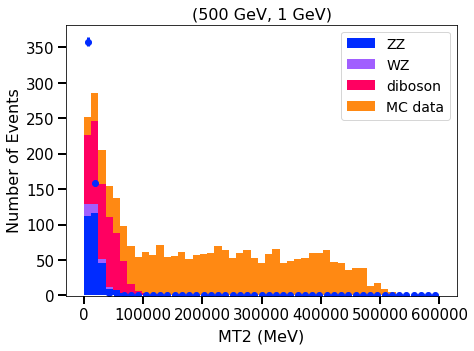

In [538]:
make_fig("MT2 (MeV)", "Number of Events")
title("(500 GeV, 1 GeV)")
n, bins, patches = plt.hist(mt2_dbg[0][1:] + [mt2_sets_ind[0]], bins, stacked = True, weights = bg_weights_ind[0] + [sets_weights_ind[0]])
errorbar(bin_centers, counts, yerr = err, fmt = 'o')
legend(["ZZ", "WZ", "diboson", "MC data"])

In [488]:
len(mt2_dbg[0][1:] + [mt2_sets_ind[0]])

4

In [497]:
sets_weights_ind[0]

array([6.1082908e-05, 7.3752759e-05, 8.9901063e-05, ..., 1.5948247e-04,
       1.0141985e-04, 1.5745078e-04], dtype=float32)

array([1.00000000e+00, 2.50009583e+04, 5.00009167e+04, 7.50008750e+04,
       1.00000833e+05, 1.25000792e+05, 1.50000750e+05, 1.75000708e+05,
       2.00000667e+05, 2.25000625e+05, 2.50000583e+05, 2.75000542e+05,
       3.00000500e+05, 3.25000458e+05, 3.50000417e+05, 3.75000375e+05,
       4.00000333e+05, 4.25000292e+05, 4.50000250e+05, 4.75000208e+05,
       5.00000167e+05, 5.25000125e+05, 5.50000083e+05, 5.75000042e+05,
       6.00000000e+05])